# Nosso Trabalho :D

## Parte 0: Bibliotecas e Configurações de Ambiente

Execute este comando abaixo se for necessário instalar as bibliotecas, lembrando que estamos utilizando o Python 3.11

In [43]:
%pip install -r requirements.txt

  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (768.5 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp311-cp311-linux_x86_64.whl (3.4 MB)
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp311-cp311-linux_x86_64.whl (7.3 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Vamos importar nossas bibliotecas essenciais primeiro

In [ ]:
import os
import re
import pandas as pd
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms

from torchcam.methods import SmoothGradCAMpp

from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Dependendo do ambiente de execução, o hardware pode ser outro, então precisamos tirar qual device está sendo usado

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Natural Language Toolkit (nltk):

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/xoxoluxa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/xoxoluxa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Parte 1: Funções Auxiliares e Classes

### Funções

NLTK: Limpeza de texto por stopwords

In [5]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    cleaned = []
    for tok in tokens:
        if tok in stop_words:
            continue
        cleaned.append(stemmer.stem(tok))
    return ' '.join(cleaned)

Treino

In [ ]:
def train(model,optimizer,criterion,train_loader,val_loader,num_epochs=10):
    """
    Executa o treinamento e validação por num_epochs e depois
    retorna 4 listas: train_losses, train_accs, val_losses e val_accs.
    """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        # Itera sobre batches de treino, sendo que o loader retorna (images, labels, caption)
        for images, labels, _ in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Acumula loss
            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            # Acumula acertos para train acc
            _, preds = torch.max(outputs, dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += batch_size


        epoch_train_loss = running_loss / running_total
        epoch_train_acc = running_correct / running_total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")

        ## Etapa de avaliação
        model.eval()
        val_running_loss = 0.0
        val_running_correct = 0
        val_running_total = 0

        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = criterion(outputs, labels)

                batch_size = images.size(0)
                val_running_loss += loss.item() * batch_size

                _, preds = torch.max(outputs, dim=1)
                val_running_correct += (preds == labels).sum().item()
                val_running_total += batch_size

        epoch_val_loss = val_running_loss / val_running_total
        epoch_val_acc = val_running_correct / val_running_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"           Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    return train_losses, train_accs, val_losses, val_accs

Plot avaliador de treino

In [ ]:
def plot_trainval_graphs(train_losses, train_accs, val_losses, val_accs):
  epochs_range = range(1, len(train_losses) + 1)

  plt.figure(figsize=(8, 4))
  plt.plot(epochs_range, train_losses, label='Train Loss')
  plt.plot(epochs_range, val_losses, label='Val Loss')
  plt.xlabel('Época')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(8, 4))
  plt.plot(epochs_range, train_accs, label='Train Acc')
  plt.plot(epochs_range, val_accs, label='Val Acc')
  plt.xlabel('Época')
  plt.ylabel('Acurácia')
  plt.title('Acurácia por Época')
  plt.legend()
  plt.grid(True)
  plt.show()

Subfunção Precisão por Classe

In [ ]:
def get_acc_per_class(model,loader):
  acc_count = np.zeros(len(classes)) ## conta casos em que pred==truelabel (acertou predizendo a classe X)
  error_count = np.zeros(len(classes)) ## conta casos em que predizeu X e a classe era Y, nesse caso error_count[X]+=1 (errou predizendo a classe X)
  total_class_count = np.zeros(len(classes))
  
  for images, labels_true, captions in loader:
    images = images.to(device, non_blocking=True)

    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)

    for i,label_true in enumerate(labels_true):
      if int(label_true) == int(preds[i]):
        acc_count[label_true]+=1
      else:
        error_count[int(preds[i])]+=1
      total_class_count[label_true]+=1
    acc_count /= total_class_count
    error_count /= sum(error_count) ## normaliza para todas as predições
  return acc_count,error_count ## (acurácia por classe , proporções de predições feitas erradas por classe)

Plotter de precisão por Classe

In [ ]:
def plot_acc_per_class(model,loaders:list):
  """
  Plota o gráfico de acurácia por classe para os dados de treino, validação e teste.
  Args:
    loaders (list): lista de loaders (train_loader, val_loader, test_loader)
    dfs (list): lista de dataframes (df_train, df_val, df_test)
  """
  fig,axs = plt.subplots(2,3,figsize=(6*3,4*2))
  plt.title("Acurácia e erro por classe")

  train_acc_perclass,train_error_perclass = get_acc_per_class(model,train_loader)
  ax = axs[0][0]
  ax.set_title("Acertou predizendo [train]")
  ax.bar(np.arange(len(classes)),train_acc_perclass)
  ax.set_ylabel("% de acerto")
  ax.set_xticks(np.arange(len(classes)),classes)
  ax = axs[1][0]
  ax.set_title("Errou predizendo [train]")
  ax.bar(np.arange(len(classes)),train_error_perclass)
  ax.set_ylabel("proporção da predição")
  ax.set_xticks(np.arange(len(classes)),classes)

  val_acc_perclass,val_error_perclass = get_acc_per_class(model,val_loader)
  ax = axs[0][1]
  ax.set_title("Acertou predizendo [val]")
  ax.bar(np.arange(len(classes)),val_acc_perclass)
  ax.set_ylabel("% de acerto")
  ax.set_xticks(np.arange(len(classes)),classes)
  ax = axs[1][1]
  ax.set_title("Errou predizendo [val]")
  ax.bar(np.arange(len(classes)),val_error_perclass)
  ax.set_ylabel("proporção da predição")
  ax.set_xticks(np.arange(len(classes)),classes)

  test_acc_perclass,test_error_perclass = get_acc_per_class(model,test_loader)
  ax = axs[0][2]
  ax.set_title("Acertou predizendo [test]")
  ax.bar(np.arange(len(classes)),test_acc_perclass)
  ax.set_ylabel("% de acerto")
  ax.set_xticks(np.arange(len(classes)),classes)
  ax = axs[1][2]
  ax.set_title("Errou predizendo [test]")
  ax.bar(np.arange(len(classes)),test_error_perclass)
  ax.set_ylabel("proporção da predição")
  ax.set_xticks(np.arange(len(classes)),classes)

  plt.show()

  train_labels = [element[1] for element in train_dataset]
  val_labels = [element[1] for element in train_dataset]
  test_labels = [element[1] for element in train_dataset]

  print("\nQuantidade de labels em cada conjunto: ")
  print("Treino   : ",np.unique(train_labels,return_counts=True))
  print("Validação: ",np.unique(test_labels,return_counts=True))
  print("Teste    : ",np.unique(val_labels,return_counts=True))

TorchCAM

In [ ]:
def get_cam_img(model,target_layer,input_tensor,threshold=90,alpha = 0.9):
  cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)
  with torch.enable_grad():
      output = model(input_tensor)
  class_idx = output.squeeze(0).argmax().item()

  activation_maps = cam_extractor(class_idx, output)
  activation_map = activation_maps[0] if isinstance(activation_maps, list) else activation_maps
  if activation_map.ndim == 3 and activation_map.shape[0] == 1:
      activation_map = activation_map.squeeze(0)  # de (1,H,W) para (H,W)

  cam = activation_map.unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
  cam_upsampled = F.interpolate(cam, size=(224,224), mode='bilinear', align_corners=False)
  cam_np = cam_upsampled.squeeze().cpu().detach().numpy()  # (224,224)
  cam_np -= cam_np.min()
  if cam_np.max() > 0:
      cam_np /= cam_np.max()

  img_np = input_tensor.squeeze(0).cpu().detach().numpy().transpose(1,2,0)
  threshold = np.percentile(cam_np, threshold)
  mask = cam_np > threshold

  cmap = plt.cm.viridis
  alpha = np.clip((cam_np - threshold) / (1 - threshold), 0, 1) * 0.6
  heatmap = cmap(cam_np)
  heatmap[..., 3] = mask * alpha
  return img_np,heatmap

## Mostrando por classe como fica a verificação
def get_cams_per_class(model,loader,target_layer,n_perclass = 5,threshold=60,alpha=0.9):
  cam_imgs_per_class = []
  for i in range(len(classes)):
    cam_imgs_per_class.append([])
  loop = True
  loader_iter = iter(loader)
  while loop:
    images_batch, labels_batch, captions_batch = next(loader_iter)
    images_batch = images_batch.to(device, non_blocking=True)
    labels_batch = labels_batch.to(device, non_blocking=True)

    loop = False
    for idx in range(len(images_batch)):
      label = int(labels_batch[idx].cpu())
      if len(cam_imgs_per_class[label]) >= n_perclass: ## já tem o suficiente
        continue

      loop = True
      input_tensor = images_batch[idx].unsqueeze(0).clone().detach().to(device)
      input_tensor.requires_grad_(True)
      caption = captions_batch[idx]
      img_np,heatmap = get_cam_img(model,target_layer,input_tensor,threshold=threshold,alpha = alpha)
      output = model(input_tensor)
      _, pred = torch.max(output, dim=1)
      cam_imgs_per_class[label].append((img_np,heatmap,caption,label,int(pred)))
  return cam_imgs_per_class

### Classes

Image Dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None, label_map=None,
                 file_column='file',label_column='label',caption_column='caption'):
        self.df = df.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map
        self.file_column=file_column
        self.label_column=label_column
        self.caption_column=caption_column

        if file_column not in df.columns or label_column not in df.columns:
            raise ValueError("Precisa das colunas de label e nome do arquivo")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.df.iloc[idx]
        img_name = row[self.file_column]
        label = row[self.label_column]
        caption = row[self.caption_column]

        ## Abre a imagem
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Converte label se necessário
        if self.label_map is not None:
            label = self.label_map[label]
        else:
            label = int(label)

        # Aplica transform se houver
        if self.transform:
            image = self.transform(image)

        return image, label, caption

SimpleCNN

In [105]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_conv=0.3, dropout_fc=0.5):
        """
        Args:
            num_classes (int): número de classes na saída.
            dropout_conv (float): probabilidade de dropout após blocos de conv (opcional).
            dropout_fc (float): probabilidade de dropout nas camadas fully-connected.
        """
        super(SimpleCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_conv)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(p=dropout_conv)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_fc),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [106]:
class ResnetCNN(nn.Module):
    def __init__(self, num_classes=10, pretrained=True, dropout_fc=0.5):
        """
        Args:
            num_classes (int): número de classes na saída.
            pretrained (bool): se deve carregar pesos pré-treinados da ResNet50.
            dropout_fc (float): probabilidade de dropout nas camadas fully-connected.
        """
        super(ResnetCNN, self).__init__()

        ## tirando o backbone da resnet e deixando pra ele não treinar
        resnet = models.resnet50(pretrained=pretrained)
        for param in resnet.parameters():
            param.requires_grad = False
        self.backbone = nn.Sequential(*list(resnet.children())[:-2]) ## tira as ultimas camadas

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        in_features = resnet.fc.in_features

        ## parte do classificador
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_fc),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x

## Parte 2: Configuração e Análise do Dataset

Para este trabalho estamos utilizando o Flickr 8k Dataset

Vamos contruir nosso dataframe primeiro antes de manipular qualquer coisa:

In [6]:
raw_data_path = './data/raw/flickr8k'

# Criando nosso dataframe inicial
df = pd.read_csv(raw_data_path+'/captions.txt',sep=',',header=None,skiprows=1,names=['image', 'caption'])
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


Note que há muito texto de baixa utilidade nas captions, precisamos limpar primeiro antes de utilizar, para isso, vamos utilizar algumas ferramentas do NLTK

Teste do NLTK em extração de stopwords de strings

In [7]:
if __name__ == "__main__":
    examples = [
        "This is a sample sentence, to test removal of stopwords and stemming.",
        "Another example: NLTK-based preprocessing!"
    ]
    for s in examples:
        print(clean_text(s))

sampl sentenc test remov stopword stem
anoth exampl nltk base preprocess


Utilizando este extrator, vamos limpar nossas captions para serem mais utilizáveis com o modelos

In [8]:
df['cleaned'] = df['caption'].apply(clean_text)
df.head()

,image,caption,cleaned
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child pink dress climb set stair entri way
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,girl go wooden build
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,littl girl climb wooden playhous
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,littl girl climb stair playhous
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,littl girl pink dress go wooden cabin


Vamos processar as captions com o CountVectorizer para extrair uma array utilizável de indexadores codificados

In [9]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['cleaned'].to_list())
names = vectorizer.get_feature_names_out()

# print(*names, sep="\n")
print(names)

['08' '10' '104' ... 'zone' 'zoo' 'zoom']


Com isso, conseguimos extrair a frequência das palavras em nosso dataset:

In [10]:
somado = np.sum(X.toarray(),axis=0)
idxs = np.argsort(somado)[::-1]
print(names[idxs])
nomes = {names[idx]:somado[idx] for idx in idxs}

for i,(k,v) in enumerate(nomes.items()):
  print(f"{k:10}{v:5}")
  if i>30:
    break

['dog' 'man' 'two' ... 'loav' 'loader' '08']
dog       10263
man        7284
two        5643
boy        4247
girl       4172
white      3960
black      3848
woman      3402
run        3367
play       3340
wear       3226
stand      3175
jump       2891
peopl      2885
water      2825
red        2692
young      2630
brown      2578
sit        2305
blue       2282
shirt      2099
walk       2040
hold       1883
ball       1849
littl      1768
grass      1626
ride       1620
snow       1558
person     1546
child      1546
look       1520
three      1387


Utilizaremos os classificadores que identificarão "cachorros, homens, mulheres, crianças, água, bolas, carros e neve" para nossos modelos deste trabalho

Os dez classificadores que usaremos são objetos de alta frequência destas imagens

In [11]:
# As classes são valores de alta frequência que encontramos no dataset
classes = ['dog','man','woman','child','water','ball','car','snow']
class2label = {classes[i]:i for i in range(len(classes))}
label2class = {i:classes[i] for i in range(len(classes))}

# Vamos criar um novo dataframe, agora, com os labels das classes que serão avaliadas
df['in_class'] = df['cleaned'].apply(lambda x: any([word in classes for word in x.split()]))
df_filtered = df[df['in_class']].copy()
df_filtered['label'] = df_filtered['cleaned'].apply(lambda x: [class2label[word] for word in x.split() if word in classes][0])

df_filtered.head(25)

,image,caption,cleaned,in_class,label
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,child pink dress climb set stair entri way,True,3
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,black dog spot dog fight,True,0
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,black dog tri color dog play road,True,0
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...,black dog white dog brown spot stare street,True,0
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...,two dog differ breed look road,True,0
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,two dog pavement move toward,True,0
15,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .,man lay bench dog sit,True,1
16,1003163366_44323f5815.jpg,A man lays on the bench to which a white dog i...,man lay bench white dog also tie,True,1
17,1003163366_44323f5815.jpg,a man sleeping on a bench outside with a white...,man sleep bench outsid white black dog sit next,True,1
18,1003163366_44323f5815.jpg,A shirtless man lies on a park bench with his ...,shirtless man lie park bench dog,True,1


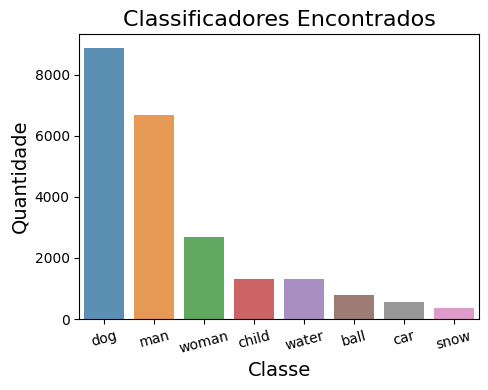

In [ ]:
classes_counts = df_filtered['label'].value_counts().sort_values(ascending=False)

sns.set_palette("tab10", 10)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
sns.barplot(x=classes, y=classes_counts.values, alpha=0.8, hue=classes_counts.index, palette="tab10", ax=axes, legend=False)

axes.set_title('Classificadores Encontrados', fontsize=16)
axes.set_xlabel('Classe', fontsize=14)
axes.set_ylabel('Quantidade', fontsize=14)
axes.set_xticks(classes)
axes.set_xticklabels(classes, rotation=15)
fig.subplots_adjust(top=0.7, right=0.7)
plt.tight_layout()

plt.show()

In [95]:
n_samples = 1000
samples_per_class = int(n_samples/df_filtered['label'].nunique())
samples_indexes = set()
for label in df_filtered['label'].unique():
  indexes = np.array(df_filtered[df_filtered['label']==label].sample(samples_per_class).index)
  samples_indexes = samples_indexes.union(set(indexes))

samples_indexes = list(samples_indexes)
df_samples = df_filtered.loc[samples_indexes]
df_samples.head()

,image,caption,cleaned,in_class,label
38912,590445887_4d4fa43923.jpg,A woman with green hair hula hoops before a cr...,woman green hair hula hoop crowd,True,2
26625,3372340429_91c4f4af30.jpg,a few dogs jumping around in the snow,dog jump around snow,True,0
14338,2759089516_cbb993cb92.jpg,A child wearing pink soled sneakers is climbin...,child wear pink sole sneaker climb headfirst w...,True,3
6148,2209496328_2a34fd201d.jpg,A white dog swims through the water with a red...,white dog swim water red toy,True,0
38919,597543181_6a85ef4c17.jpg,a young child swinging on a green swing .,young child swing green swing,True,3


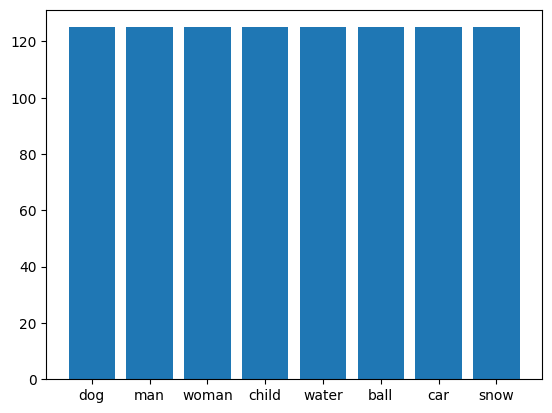

In [96]:
import matplotlib.pyplot as plt
classes_counts = np.array(df_samples['label'].value_counts().to_list())
plt.bar(np.arange(len(classes)),classes_counts)
plt.xticks(np.arange(len(classes)),classes)
plt.show()

In [99]:
df_samples.columns
df_samples.index
type(df_samples.iloc[0]['label'])
df_samples = df_samples.reset_index()
df_samples = df_samples[['image', 'caption', 'label']]
#df_samples['label'] = df_samples['label'].astype(float) 
df_samples

,image,caption,label
0,590445887_4d4fa43923.jpg,A woman with green hair hula hoops before a cr...,2
1,3372340429_91c4f4af30.jpg,a few dogs jumping around in the snow,0
2,2759089516_cbb993cb92.jpg,A child wearing pink soled sneakers is climbin...,3
3,2209496328_2a34fd201d.jpg,A white dog swims through the water with a red...,0
4,597543181_6a85ef4c17.jpg,a young child swinging on a green swing .,3
...,...,...,...
995,584484388_0eeb36d03d.jpg,Two little wiener dogs are running on the gras...,0
996,2890057168_c712f932e0.jpg,Two adults and a child wait to cross a street .,3
997,2623146491_b64698b875.jpg,Man standing at a check-out counter .,1
998,3210359094_ee51285301.jpg,A child playing in snow .,3


In [ ]:
image_dim = (224,224) ## bota as imagens para uma dimensão só
transform = transforms.Compose([
    transforms.Resize(image_dim),
    transforms.ToTensor(),
])


flickr8k_cleaned = ImageDataset(df_samples, raw_data_path+'/Images', file_column='image',transform=transform)
print(f"image data: {flickr8k_cleaned[0][0][0]}")
print(f"label: {flickr8k_cleaned[0][1]}")
print(f"caption: {flickr8k_cleaned[0][2]}")

#### Preparação para treino

In [102]:
train, test = torch.utils.data.random_split(flickr8k_cleaned, [0.8, 0.2])
save_dir = './data/processed'
torch.save(flickr8k_cleaned, save_dir+'/mini_flickr8k.pt')
torch.save(train, save_dir+'/train_subset.pt')
torch.save(test, save_dir+'/test_subset.pt')


In [103]:
data = torch.load(save_dir+'/mini_flickr8k.pt', weights_only=False)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.75, 0.125, 0.125])
train_dataset[0]

(tensor([[[0.7961, 0.7961, 0.7961,  ..., 0.8000, 0.7961, 0.8000],
          [0.7098, 0.7020, 0.6980,  ..., 0.8510, 0.8510, 0.8392],
          [0.0706, 0.0588, 0.0588,  ..., 0.5686, 0.5686, 0.5569],
          ...,
          [0.6667, 0.6745, 0.6784,  ..., 0.6941, 0.6902, 0.6902],
          [0.6549, 0.6431, 0.6627,  ..., 0.6941, 0.6863, 0.6784],
          [0.6863, 0.6784, 0.6627,  ..., 0.6980, 0.7020, 0.6980]],
 
         [[0.7961, 0.7961, 0.7961,  ..., 0.8000, 0.7961, 0.8000],
          [0.7098, 0.7020, 0.6980,  ..., 0.8510, 0.8510, 0.8392],
          [0.0706, 0.0627, 0.0588,  ..., 0.5647, 0.5647, 0.5529],
          ...,
          [0.6588, 0.6667, 0.6745,  ..., 0.6824, 0.6784, 0.6784],
          [0.6314, 0.6275, 0.6549,  ..., 0.6863, 0.6784, 0.6667],
          [0.6824, 0.6706, 0.6588,  ..., 0.6941, 0.6980, 0.6941]],
 
         [[0.7961, 0.7961, 0.7961,  ..., 0.8000, 0.8000, 0.8000],
          [0.7059, 0.7020, 0.6980,  ..., 0.8588, 0.8588, 0.8471],
          [0.0549, 0.0471, 0.0471,  ...,

In [104]:
## Fazendo os loaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader   = DataLoader(test_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

## Parte 3: Simple Model

In [ ]:
simpleModel = SimpleCNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simpleModel.parameters(), lr=1e-3)
num_epochs = 10

train_losses, train_accs, val_losses, val_accs = train(simpleModel,optimizer,criterion,train_loader,val_loader,num_epochs)
plot_trainval_graphs(train_losses, train_accs, val_losses, val_accs)

In [ ]:
#torch.save(model, './models/flickrcnn.pt')

O modelo está sendo treinado por muito poucas épocas, não é tão potente e não estão sendo feitas técnicas para aumentar a robustez das predições como Data Augmentation, então já era esperado que o modelo não desempenhasse bem. Isso foi praticamente um exemplo didático do funcionamento da cnn.

O dataset é bem complicado, então já é esperado que ele não desempenhe bem, mas aparentemente ele está conseguindo acertar mais da classe 'snow' e 'dog'. Dito isso, vamos tentar usar [Class Activation Map](https://github.com/frgfm/torch-cam) para tentar entender o funcionamento interno da rede.

In [ ]:
n_perclass = 5
figsize = (5,5)
cam_imgs_per_class = get_cams_per_class(model,train_loader,n_perclass = n_perclass,target_layer='block1')

for class_idx, cams_imgs in enumerate(cam_imgs_per_class):
  fig,axs = plt.subplots(1,5,figsize=(figsize[0]*n_perclass,figsize[1]*1))

  ## mostra as imagens nos ax
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    ax = axs[img_count]
    ax.imshow(img_np)
    ax.imshow(heatmap)
    ax.set_title(f"img {img_count}")
    ax.axis('off')
  fig.suptitle(f"CAM para a classe {label2class[class_idx]}")
  plt.show()

  ## printa as captions e labels e preds
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    true_class = label2class[label]
    pred_class = label2class[pred]
    print(f"{img_count:5} --- true: {true_class:10} pred: {pred_class:10} caption: {caption}")
  print("\n\n")


## Parte 4: Resnet

In [ ]:
classes = ['dog','man','woman','child','water','ball','car','snow']
class2label = {classes[i]:i for i in range(len(classes))}
label2class = {i:classes[i] for i in range(len(classes))}

#carregando dataset
whole_train_data = torch.load('./data/processed/train_subset.pt', weights_only=False)
train_dataset, val_dataset= torch.utils.data.random_split(whole_train_data, [0.8, 0.2])

## Fazendo os loaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

In [ ]:
model_resnet = ResnetCNN(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-3)
num_epochs = 30

train_losses, train_accs, val_losses, val_accs = train(model_resnet,optimizer,criterion,train_loader,val_loader,num_epochs, device=device)
plot_trainval_graphs(train_losses, train_accs, val_losses, val_accs)

In [ ]:
#torch.save(model_resnet, './models/resnet_based.pt')

## Parte 5: Validação dos Modelos

In [ ]:
#definindo classes
classes = ['dog','man','woman','child','water','ball','car','snow']
class2label = {classes[i]:i for i in range(len(classes))}
label2class = {i:classes[i] for i in range(len(classes))}

#carregando modelos
simple_model = torch.load('./models/flickrcnn.pt', weights_only=False, map_location=torch.device(device))
resnet_model = torch.load('./models/resnet_based.pt', weights_only=False, map_location=torch.device(device))

#carregando dataset
whole_train_data = torch.load('./data/processed/train_subset.pt', weights_only=False)
test_dataset = torch.load('./data/processed/test_subset.pt', weights_only=False)
train_dataset, val_dataset= torch.utils.data.random_split(whole_train_data, [0.8, 0.2])

## Fazendo os loaders
batch_size = 32
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)
test_loader   = DataLoader(test_dataset,   batch_size=batch_size, shuffle=False,
                          num_workers=num_workers, pin_memory=True)

### Simple

In [ ]:
plot_acc_per_class(simple_model,(train_loader,val_loader,test_loader))

In [ ]:
n_perclass = 5
figsize = (5,5)
cam_imgs_per_class = get_cams_per_class(simple_model,train_loader,n_perclass = n_perclass,target_layer='block1')

for class_idx, cams_imgs in enumerate(cam_imgs_per_class):
  fig,axs = plt.subplots(1,5,figsize=(figsize[0]*n_perclass,figsize[1]*1))

  ## mostra as imagens nos ax
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    ax = axs[img_count]
    ax.imshow(img_np)
    ax.imshow(heatmap)
    ax.set_title(f"img {img_count}")
    ax.axis('off')
  fig.suptitle(f"CAM para a classe {label2class[class_idx]}")
  plt.show()

  ## printa as captions e labels e preds
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    true_class = label2class[label]
    pred_class = label2class[pred]
    print(f"{img_count:5} --- true: {true_class:10} pred: {pred_class:10} caption: {caption}")
  print("\n\n")


### Resnet

In [ ]:
plot_acc_per_class(resnet_model,(train_loader,val_loader,test_loader))

In [ ]:
n_perclass = 5
figsize = (5,5)
cam_imgs_per_class = get_cams_per_class(resnet_model,train_loader,n_perclass = n_perclass,target_layer=resnet_model.backbone[-1])

for class_idx, cams_imgs in enumerate(cam_imgs_per_class):
  fig,axs = plt.subplots(1,5,figsize=(figsize[0]*n_perclass,figsize[1]*1))

  ## mostra as imagens nos ax
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    ax = axs[img_count]
    ax.imshow(img_np)
    ax.imshow(heatmap)
    ax.set_title(f"img {img_count}")
    ax.axis('off')
  fig.suptitle(f"CAM para a classe {label2class[class_idx]}")
  plt.show()

  ## printa as captions e labels e preds
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    true_class = label2class[label]
    pred_class = label2class[pred]
    print(f"{img_count:5} --- true: {true_class:10} pred: {pred_class:10} caption: {caption}")
  print("\n\n")


Bom, com certeza os filtros estão melhores que na SimpleCNN. Mas como verificamos overfitting antes, vamos tentar ver o quanto isso influencia nos dados de teste

In [ ]:
n_perclass = 5
figsize = (5,5)
cam_imgs_per_class = get_cams_per_class(resnet_model,test_loader,n_perclass = n_perclass,target_layer=resnet_model.backbone[-1])

for class_idx, cams_imgs in enumerate(cam_imgs_per_class):
  fig,axs = plt.subplots(1,5,figsize=(figsize[0]*n_perclass,figsize[1]*1))

  ## mostra as imagens nos ax
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    ax = axs[img_count]
    ax.imshow(img_np)
    ax.imshow(heatmap)
    ax.set_title(f"img {img_count}")
    ax.axis('off')
  fig.suptitle(f"CAM para a classe {label2class[class_idx]}")
  plt.show()

  ## printa as captions e labels e preds
  for img_count, (img_np,heatmap,caption,label,pred) in enumerate(cams_imgs):
    true_class = label2class[label]
    pred_class = label2class[pred]
    print(f"{img_count:5} --- true: {true_class:10} pred: {pred_class:10} caption: {caption}")
  print("\n\n")


Parece que a coloração dos objetos ainda interfere e isso pode estar atrapalhando (por exemplo uma criança de camisa branca ser confundida com 'snow').

Apesar disso, existem vários casos que a rede desempenhou bem já que conseguiu achar até casos multilabel, como 'duas crianças brincando na água' (nesse exemplo ela prediz 'child', mas pela construção do dataset, seria 'water', mas a interpretação está ótima).